### The note book where I will develop the code to collate port information and produce fits

In [1]:
# import stuff
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import core.functions as func
import numpy as np
import matplotlib.pyplot as plt

### collect data from files and load

In [2]:
def collate_ports(path_array):
    '''
    Collect individual ports and apply the respective cuts to save space.

    Args:
        path_array          :           an array of folder paths to h5 files
                                        respective of the multiple ports

    
    Returns:
        array               :           output of collective ports
    '''

    for i in range(len(path_array)):
        print("Porting {}".format(path_array[i]))
        if (i==0):
            tracks = (func.load_data(path_array[i]))[0]
        else:
            nu_tracks = (func.load_data(path_array[i]))[0]
            print("Tracks: {}".format(func.len_events(nu_tracks)))
            # multiply the events numbers to avoid overlap
            nu_tracks['event'] = nu_tracks['event'] * (i+1)
            tracks = tracks.append(nu_tracks)

        print("Done! Tracks available: {}".format(func.len_events(tracks)))
    
    return tracks

def positron_ports(path_array):
    '''
    Collect positron events from multiple ports.
    Bespoke, use with care.
    '''

    for i in range(len(path_array)):
        print("Loading positrons from {}".format(path_array[i]))
        if (i==0):
            posi = func.positron_scraper(path_array[i])
        else:
            nu_posi = func.positron_scraper(path_array[i])
            print("Positron events: {}".format(func.len(nu_posi)))
            # multiple the event numbers to avoid overlap, the *2 is to match it with the tracking values
            nu_posi['event_id'] = nu_posi['event_id'] * ((i+1)*2)
            posi = posi.append(nu_posi)

        print("Port finished! Tracks available: {}".format(func.len_events(posi)))
    
    return posi


In [3]:
folder_paths = ['75_9e-3/PORT_1a/isaura/', '75_9e-3/PORT_1b/isaura/', '75_9e-3/PORT_2a/isaura/']
full_tracks = collate_ports(folder_paths)

Porting 75_9e-3/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009
Porting 75_9e-3/PORT_1b/isaura/
50
100
150
200
250
300
Tracks: 84703
Done! Tracks available: 152826
Porting 75_9e-3/PORT_2a/isaura/
50
100
150
200
250
300
Tracks: 60529
Done! Tracks available: 198973


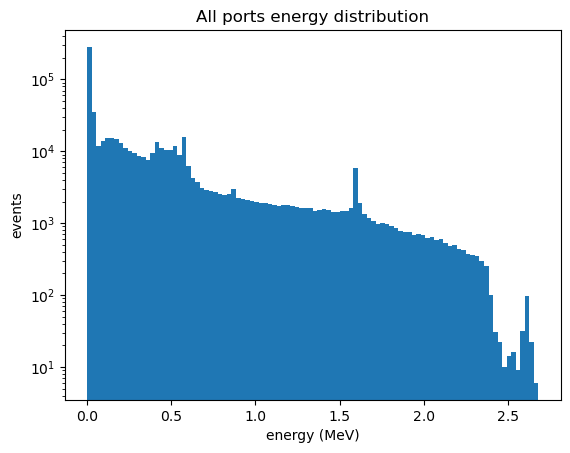

In [4]:
func.plot_hist(full_tracks, binning = 100, title='All ports energy distribution')

In [5]:
# satellite merge
low_e_tracks = func.remove_low_E_events(full_tracks)

cut_tracks = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)

/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)


Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 40.72 %
Absolute Cut efficiency:
Efficiency: 40.72 %
One track cut
Relative Cut efficiency:
Efficiency: 64.68 %
Absolute Cut efficiency:
Efficiency: 53.25 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 72.55 %
Absolute Cut efficiency:
Efficiency: 71.49 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.78 %
Absolute Cut efficiency:
Efficiency: 7.61 %


4098


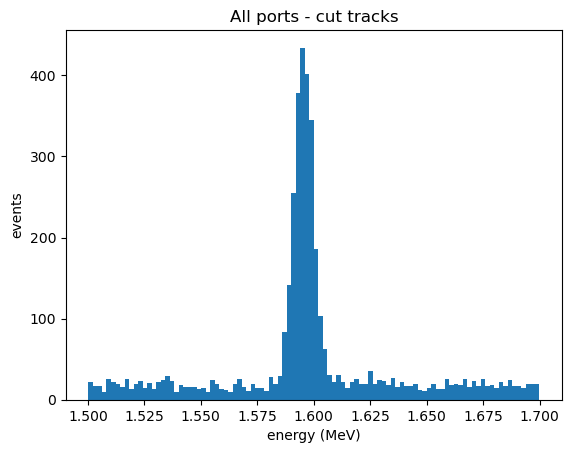

In [6]:
func.plot_hist(cut_tracks[0], binning = 100, title='All ports - cut tracks', log = False)
print(func.len_events(cut_tracks[0]))

In [7]:
eblob_tracks = cut_tracks[0][(cut_tracks[0]['eblob2'] > 0.2)]

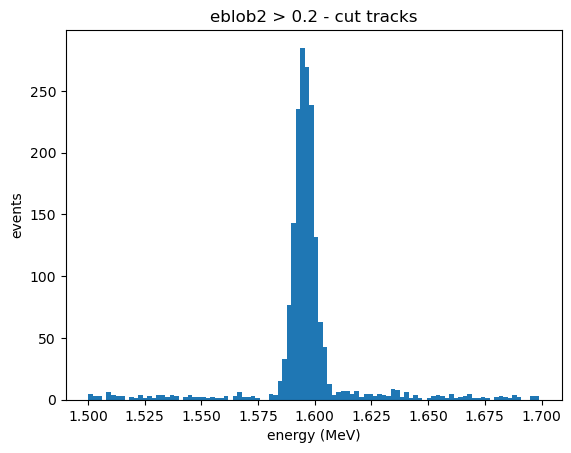

In [31]:
func.plot_hist(eblob_tracks, binning = 100, title='eblob2 > 0.2 - cut tracks', log = False)

### But now, lets create this with only positron events. How annoying!

In [8]:
# find positron events per port
pos_events = positron_ports(folder_paths)

Loading positrons from 75_9e-3/PORT_1a/isaura/


KeyError: 'event'